In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Explore preprocessed features

## Installation and import of the needed libraries


In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import and configuration setup


In [4]:
# python modules
import os
import pickle

# 3rd party modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.pipeline import make_pipeline

# user modules
from utils import util_data

In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [6]:
pd.set_option("max_colwidth", 800)

In [7]:
df = pd.read_csv("data/processed/gsm.csv", sep=",", index_col=0)
df.head()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,is_waterproof,oem_model,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,2019.0,6.30,1,0,1,0,1,1,4G,...,1,Google Pixel 4 XL,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,2019.0,5.70,1,0,1,0,1,1,4G,...,1,Google Pixel 4,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,2019.0,6.00,1,0,1,1,1,1,4G,...,0,Google Pixel 3a XL,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0
3,304.00,2019.0,5.60,1,0,1,1,1,1,4G,...,0,Google Pixel 3a,1080.0,2220.0,64.0,4.0,12.2,1.0,8.0,1.0
4,110.00,2020.0,5.71,0,1,0,1,0,0,4G,...,0,Honor 8S 2020,720.0,1520.0,64.0,3.0,13.0,1.0,5.0,1.0


In [8]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of nan values: {df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of rows: 1911
Number of nan values: 0
Number of duplicated rows: 0


## Explore the dataset

### Split in train-test set

Mean of standardized price: [269.22117345]
Scale of standardized price: [178.28635939]


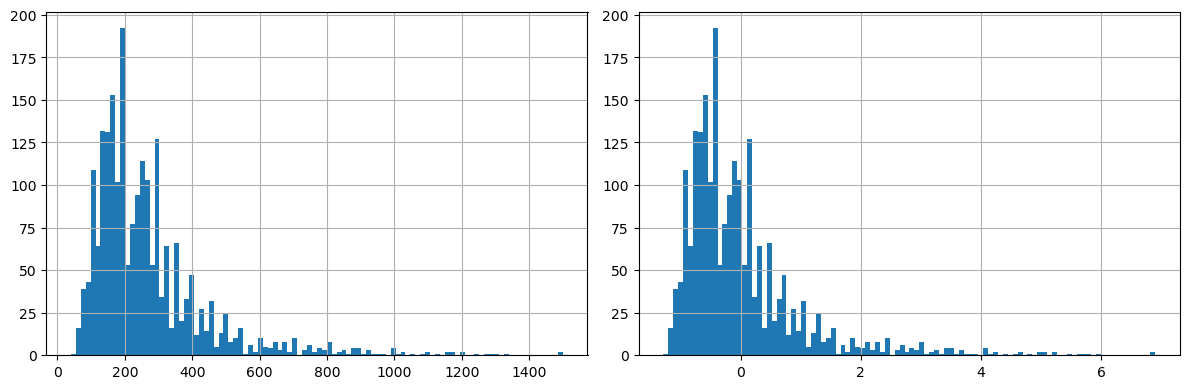

In [312]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
faxs = axs.ravel()

upper_clip = input("Clip price at upper bound? (y/n): ").lower() == "y"
price = df.misc_price.clip(upper=1500).copy() if upper_clip else df.misc_price.copy()
compute_log = input("Compute log of price? (y/n): ").lower() == "y"
if compute_log:
    price = price.apply(np.log)

price.hist(bins=100, ax=faxs[0])

std_scaler = StandardScaler()
std_price = std_scaler.fit_transform(price.values.reshape(-1, 1))
mean_price, scale_price = std_scaler.mean_, std_scaler.scale_
if compute_log:
    mean_price = np.exp(mean_price)
    # scale_price = np.exp(scale_price)

print(f"Mean of standardized price: {mean_price}")
print(f"Scale of standardized price: {scale_price}")


pd.Series(std_price.flatten()).hist(bins=100, ax=faxs[1])
plt.tight_layout()

c:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Bin 0: 50.00 - 56.46 | 4
Bin 1: 56.46 - 63.75 | 6
Bin 2: 63.75 - 71.98 | 14
Bin 3: 71.98 - 81.28 | 31
Bin 4: 81.28 - 91.78 | 32
Bin 5: 91.78 - 103.63 | 64
Bin 6: 103.63 - 117.02 | 55
Bin 7: 117.02 - 132.13 | 129
Bin 8: 132.13 - 149.20 | 67
Bin 9: 149.20 - 168.47 | 177
Bin 10: 168.47 - 190.23 | 186
Bin 11: 190.23 - 214.79 | 169
Bin 12: 214.79 - 242.54 | 129
Bin 13: 242.54 - 273.86 | 171
Bin 14: 273.86 - 309.23 | 171
Bin 15: 309.23 - 349.17 | 89
Bin 16: 349.17 - 394.27 | 98
Bin 17: 394.27 - 445.19 | 89
Bin 18: 445.19 - 502.69 | 69
Bin 19: 502.69 - 567.62 | 34
Bin 20: 567.62 - 640.93 | 29
Bin 21: 640.93 - 723.71 | 27
Bin 22: 723.71 - 817.18 | 25
Bin 23: 817.18 - 922.73 | 18
Bin 24: 922.73 - 1041.91 | 10
Bin 25: 1041.91 - 1176.47 | 9
Bin 26: 1176.47 - 1328.42 | 7
Bin 27: 1328.42 - 1500.00 | 2


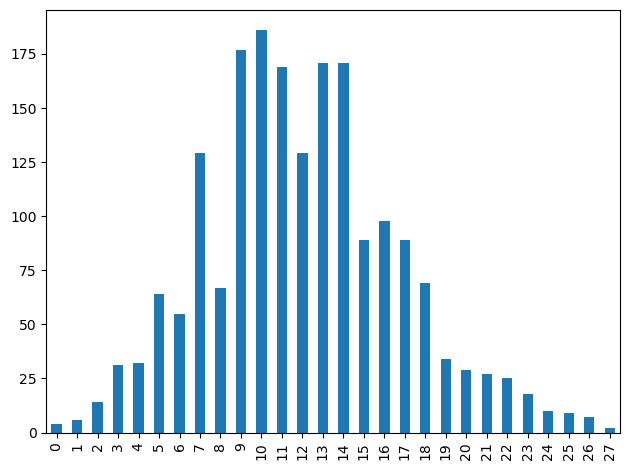

In [352]:
# class LabelEncoder(FunctionTransformer):
#     def __init__(self, bins="doane", **kwargs):
#         self.bins = bins
#         super().__init__(self.compute_label_encoding, kw_args={"bins": bins}, **kwargs)

#     def compute_label_encoding(self, x, bins):
#         _, bin_edges = np.histogram(x, bins=bins)
#         self.bin_edges_ = [bin_edges]
#         bin_edges[-1] = bin_edges[-1] + 1e-6
#         return np.digitize(x, bin_edges, right=False) - 1

clip_fun = util_data.ClipEncoder(lower=50, upper=1500, clip=True, validate=False, check_inverse=False)
log_fun = FunctionTransformer(np.log, validate=False, check_inverse=True, inverse_func=np.exp)
label_enc = util_data.LabelEncoder(bins="auto", validate=False, check_inverse=False)
# label_enc = KBinsDiscretizer(n_bins=10, encode="ordinal", subsample=None, strategy="uniform")

label_pipeline = make_pipeline(clip_fun, log_fun, label_enc)
label_pipeline.set_output(transform="pandas")
label_cat = label_pipeline.fit_transform(df[["misc_price"]]).misc_price

# get the frequency of each bin
label_cat_freq = label_cat.value_counts().sort_index()

# convert bin edges without the logarithm
bin_edges = np.exp(label_pipeline[2].bin_edges_[0])
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f} | {label_cat_freq[i] if i in label_cat_freq else 0}")

# plot the frequency of each bin
label_cat_freq.plot.bar()
plt.tight_layout()

In [353]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=rng, shuffle=True, stratify=label_cat)

In [354]:
print(f"Number of rows in train set: {df_train.shape[0]}")
print(f"Number of rows in test set: {df_test.shape[0]}")

Number of rows in train set: 1528
Number of rows in test set: 383


In [355]:
# save train and test sets
df_train.to_csv("data/processed/gsm_train.csv", index=True)
df_test.to_csv("data/processed/gsm_test.csv", index=True)

#### Launch announced

Except for the years 2011, 2012, 2013 and 2020, the dataset is balanced for the years. The year 2020 is not balanced because the dataset is not complete for this year, while in the first years the devices were not so many for the features considered (e.g. the resolution of the display was smaller than 1000 pixels).


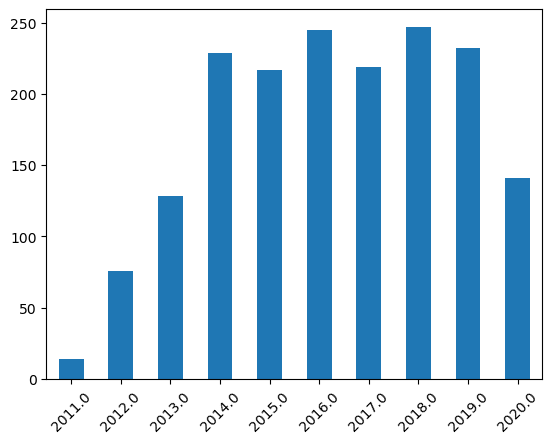

In [130]:
year_counts = df_train.launch_announced.value_counts().sort_index()

year_counts.plot(kind="bar", rot=45)
plt.show()

#### Misc price

There are many outliers which depicts the presence of some expensive devices. These devices are not removed because even this kind of devices are relevant for the task.

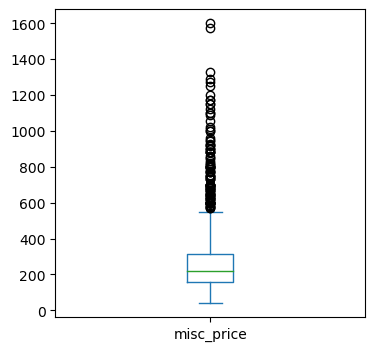

In [318]:
df_train.misc_price.plot.box(whis=1.5, figsize=(4,4))
plt.show()

In [319]:
misc_price = df.misc_price

print(f"Median: {misc_price.median()}")
print(f"Mean: {misc_price.mean()}")

misc_price.describe()

Median: 220.0
Mean: 269.29959788261954


count    2177.000000
mean      269.299598
std       178.887274
min        40.000000
25%       160.000000
50%       220.000000
75%       310.000000
max      1600.000000
Name: misc_price, dtype: float64

In [320]:
def compute_bin(x):
    if x > 380:
        return 2
    elif x > 200:
        return 1
    else:
        return 0
cat_price = misc_price.apply(compute_bin)
util_data.count_frequency_labels(cat_price).sort_index()

,Frequency,Count
0,45.11%,982
1,38.36%,835
2,16.54%,360


Distribution of the price in different years.

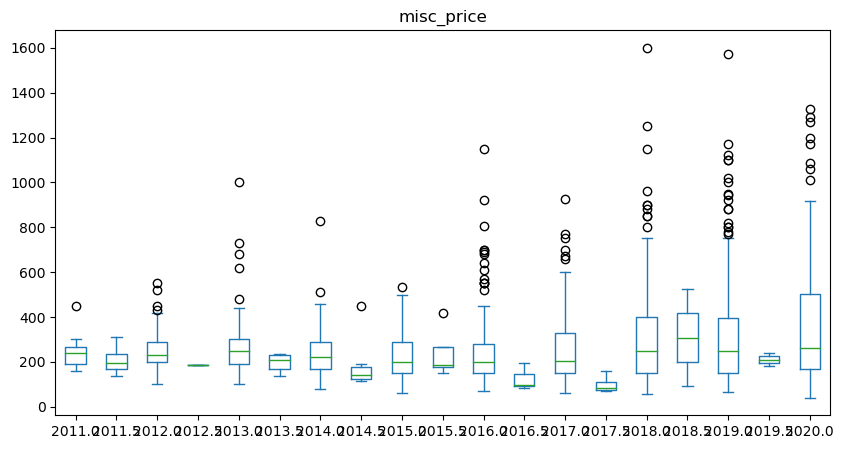

In [321]:
# show boxplot of misc_price for distinct launch_announced
df_train.plot.box(by="launch_announced", column="misc_price", figsize=(10, 5))
plt.show()

#### Display resolution size

In [220]:
size_unique: np.ndarray = df_train[["display_width", "display_height"]].apply(lambda x: f"{x[0]}|{x[1]}", axis=1).unique()
size_df = pd.DataFrame(list(map(lambda x: x.split("|"), size_unique)), columns=["display_width", "display_height"]).astype(float)
size_df.head()

,display_width,display_height
0,1080.0,1920.0
1,800.0,1280.0
2,720.0,1280.0
3,720.0,1440.0
4,540.0,960.0


<Axes: xlabel='display_width', ylabel='display_height'>

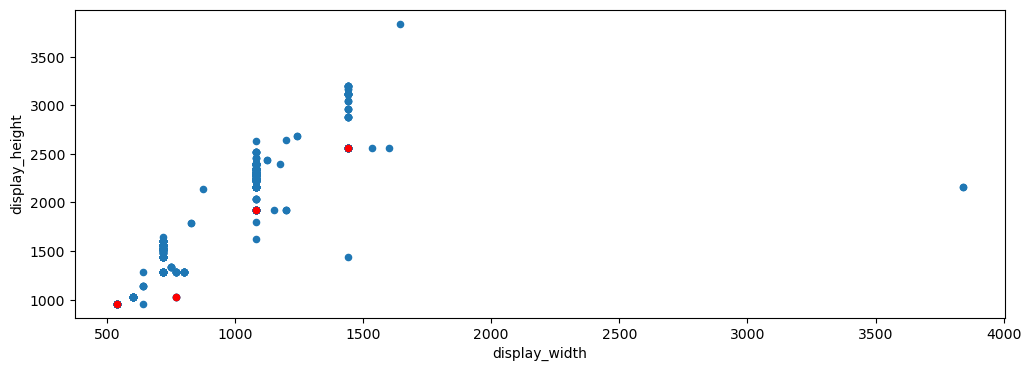

In [221]:
resolutions = {"qHD": [540, 960], "HD": [768, 1024], "FHD": [1080, 1920], "QHD": [1440, 2560]}
resolutions_df = pd.DataFrame.from_dict(resolutions, orient="index", columns=["display_width", "display_height"])

fig, axs = plt.subplots(1, figsize=(12, 4))
df_train.plot(kind="scatter", x="display_width", y="display_height", ax=axs)
resolutions_df.plot(kind="scatter", x="display_width", y="display_height", ax=axs, color="red")

#### Continuous features

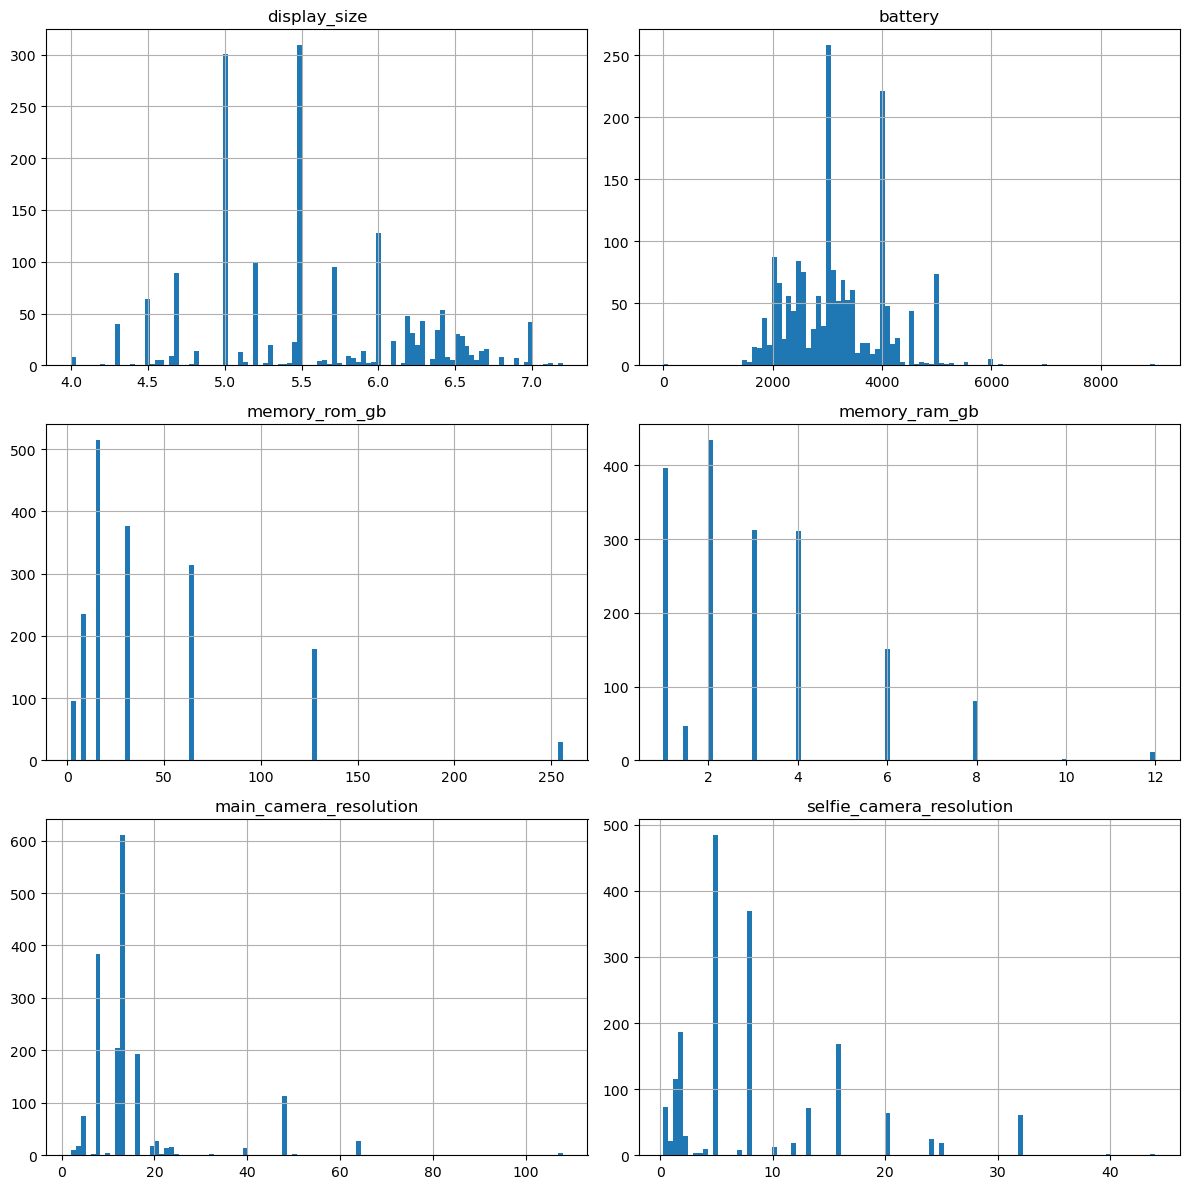

In [222]:
num_features = ["display_size", "battery", "memory_rom_gb", "memory_ram_gb", "main_camera_resolution", "selfie_camera_resolution"]
n_cols, n_rows = 2, round(len(num_features) / 2)
df_train[num_features].hist(bins=100, figsize=(6 * n_cols, 4 * n_rows), layout=(n_rows, n_cols), sharex=False, sharey=False)
plt.tight_layout()

In [225]:
tmp_raw = pd.read_csv("data/raw/gsm.csv", dtype=object)

In [239]:
res_train = df_train[df_train.memory_ram_gb == 1.5][["oem_model"]]

names_raw = tmp_raw[["oem", "model"]].apply(lambda x: x[0] + " " + x[1], axis=1)
boolean_names = names_raw.apply(lambda x: x.lower() in res_train.oem_model.str.lower().values)

tmp_raw[boolean_names][["oem", "model", "memory_internal"]]

,oem,model,memory_internal
1819,alcatel,A3,"16 GB, 1.5 GB RAM"
1860,alcatel,Idol 3 (4.7),"8 GB, 1.5 GB RAM/ 16 GB, 1.5 GB RAM (Dual SIM model)"
2763,BlackBerry,Z3,"8 GB, 1.5 GB RAM"
3852,HTC,Desire 530,"16 GB, 1.5 GB RAM"
3853,HTC,Desire 625,"8 GB, 1.5 GB RAM"
3864,HTC,Desire 526,"8 GB, 1.5 GB RAM"
3895,HTC,One Remix,"16 GB, 1.5 GB RAM"
3906,HTC,Desire 816 dual sim,"8 GB, 1.5 GB RAM"
3907,HTC,Desire 816,"8 GB, 1.5 GB RAM"
4949,LG,X power2,"16 GB, 1.5/2 GB RAM32 GB, 2 GB RAM (USA)"


### Plot of numerical feature correlations

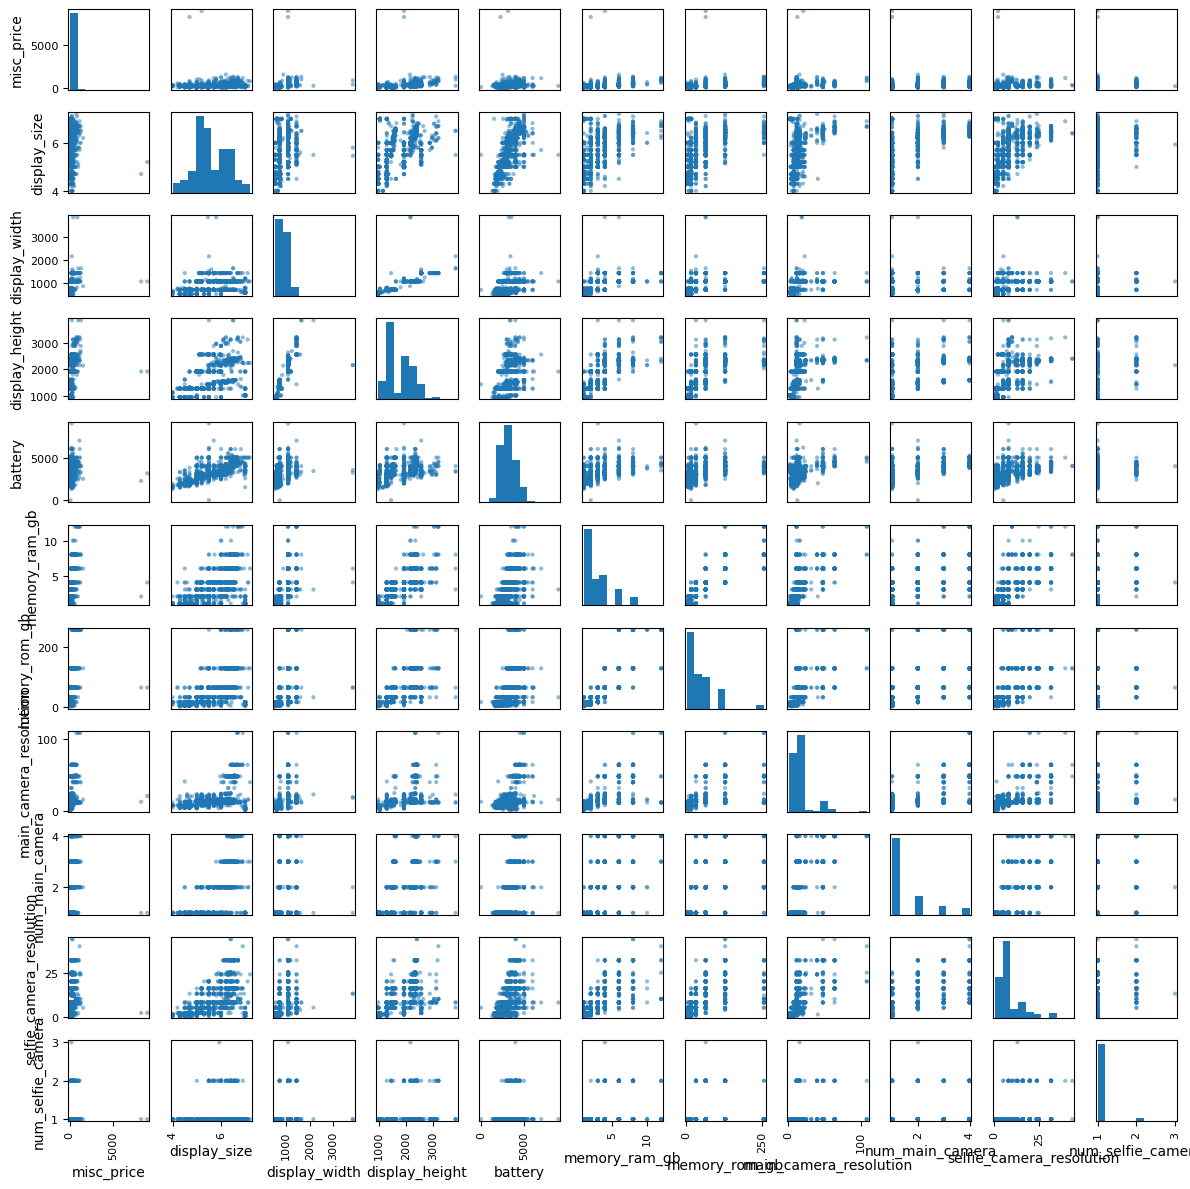

In [140]:
from pandas.plotting import scatter_matrix


attributes = [
    "misc_price",
    "display_size",
    "display_width",
    "display_height",
    "battery",
    "memory_ram_gb",
    "memory_rom_gb",
    "main_camera_resolution",
    "num_main_camera",
    "selfie_camera_resolution",
    "num_selfie_camera",
]
scatter_matrix(df_train[attributes], figsize=(12, 12))
plt.tight_layout()


### Correlation between data


In [141]:
df_train.corr(numeric_only=True)["misc_price"].sort_values(ascending=False)

misc_price                  1.000000
memory_rom_gb               0.328154
memory_ram_gb               0.319681
display_height              0.318880
has_wireless_charging       0.301513
display_width               0.296844
has_stereo_speakers         0.265086
has_wlan_5ghz               0.262969
has_nfc                     0.256727
has_oled_display            0.250465
main_camera_resolution      0.200352
is_waterproof               0.189530
selfie_camera_resolution    0.169623
num_main_camera             0.161241
display_size                0.125363
battery                     0.122559
num_selfie_camera           0.093948
launch_announced            0.072265
has_memory_card_slot       -0.242269
has_3.5mm_jack             -0.253937
Name: misc_price, dtype: float64

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.


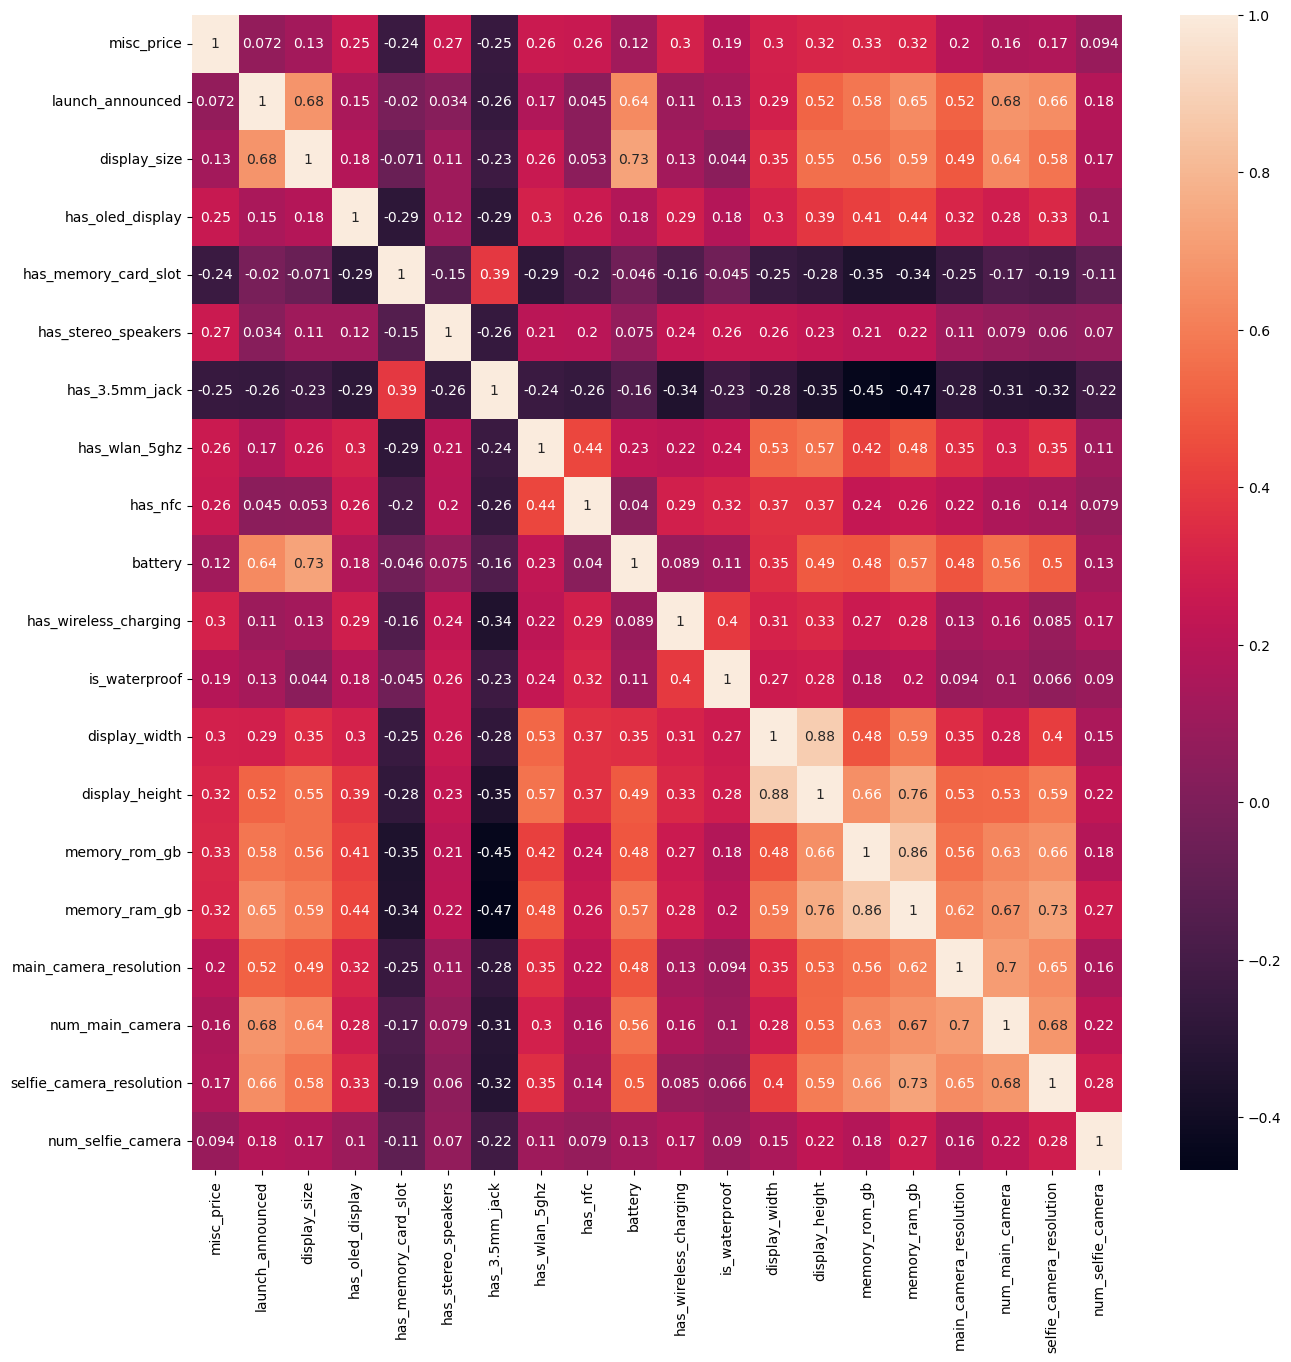

In [142]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(numeric_only=True), annot=True)
plt.show()


In [143]:
df_train.describe()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,278.154116,2016.308924,5.566533,0.230549,0.823227,0.137872,0.925629,0.539474,0.393021,3178.470824,0.059497,0.123570,906.807780,1717.394737,45.579519,3.103833,15.992363,1.507437,8.381636,1.040046
std,335.010576,2.299197,0.676884,0.421305,0.381586,0.344864,0.262448,0.498582,0.488561,881.272043,0.236619,0.329184,259.000184,515.063115,49.139871,2.015169,13.025027,0.870855,7.401426,0.199020
min,40.000000,2011.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.000000,960.000000,1.000000,1.000000,2.000000,1.000000,0.300000,1.000000
25%,160.000000,2014.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2500.000000,0.000000,0.000000,720.000000,1280.000000,16.000000,2.000000,8.000000,1.000000,4.000000,1.000000
50%,220.000000,2016.000000,5.500000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3020.000000,0.000000,0.000000,750.000000,1600.000000,32.000000,3.000000,13.000000,1.000000,5.000000,1.000000
75%,310.000000,2018.000000,6.190000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4000.000000,0.000000,0.000000,1080.000000,2160.000000,64.000000,4.000000,16.000000,2.000000,12.000000,1.000000
max,9000.000000,2020.000000,7.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9000.000000,1.000000,1.000000,3840.000000,3840.000000,256.000000,12.000000,108.000000,4.000000,44.000000,3.000000


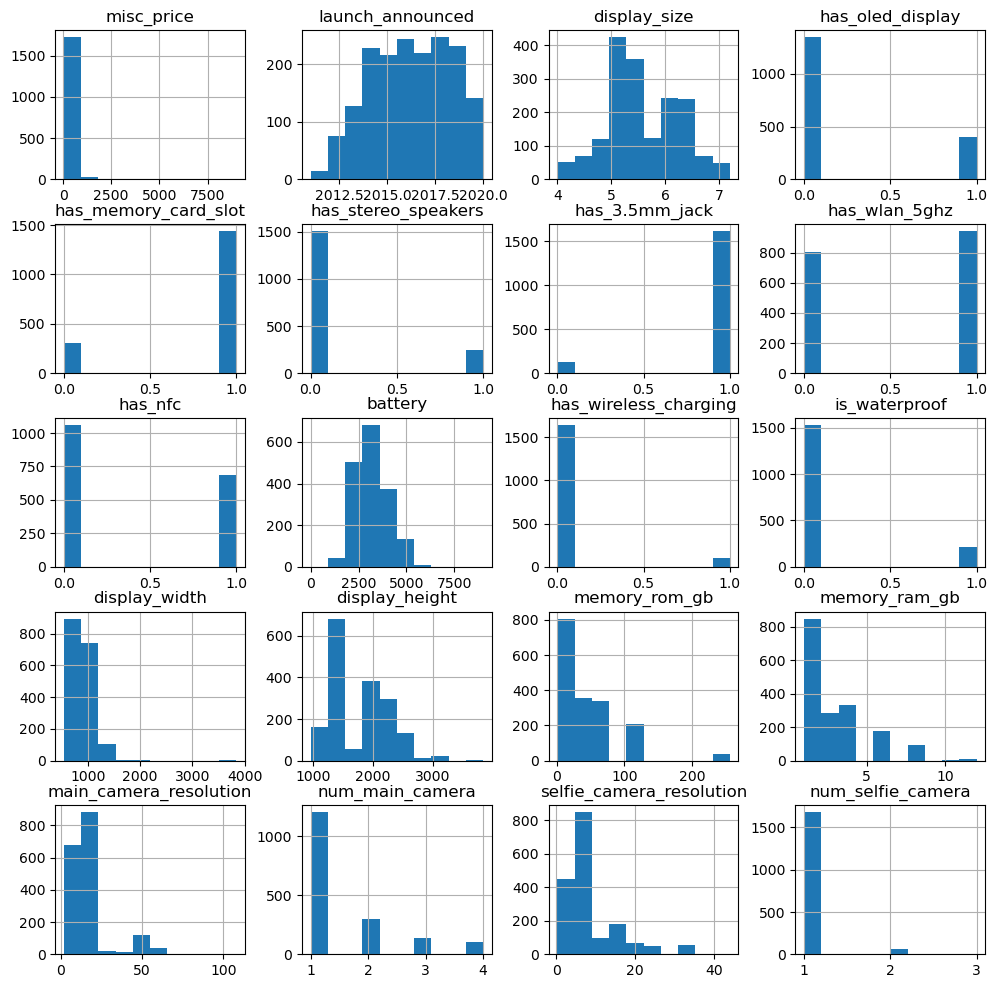

In [144]:
df_train.hist(figsize=(12, 12))
plt.show()

## Transform features

In [8]:
df_train = pd.read_csv("data/processed/gsm_train.csv", index_col=0)
df_test = pd.read_csv("data/processed/gsm_test.csv", index_col=0)

### Features

#### misc_price

Mean of standardized price: [228.43457064]
Lower bound of standardized price: [132.26001032]
Upper bound of standardized price: [394.54369418]


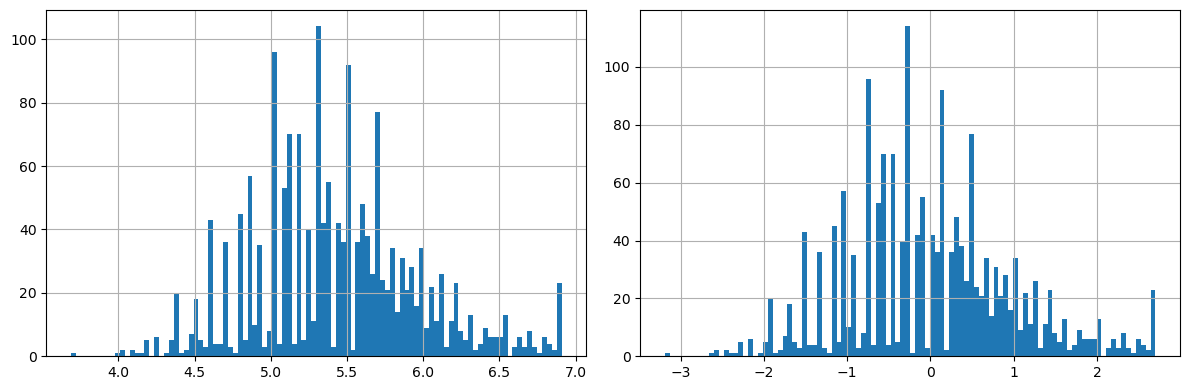

In [146]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# faxs = axs.ravel()

# # upper_clip = input("Clip price at upper bound? (y/n): ").lower() == "y"
# price = df_train.misc_price.clip(lower=None, upper=1000).copy()
# compute_log = input("Compute log of price? (y/n): ").lower() == "y"
# if compute_log:
#     price = price.apply(np.log)

# price.hist(bins=100, ax=faxs[0])

# std_scaler = StandardScaler()
# std_price = std_scaler.fit_transform(price.values.reshape(-1, 1))
# mean_price, scale_price = std_scaler.mean_, std_scaler.scale_
# if compute_log:
#     upper = np.exp(mean_price + scale_price)
#     lower = np.exp(mean_price - scale_price)
#     mean_price = np.exp(mean_price)
# else:
#     upper = mean_price + scale_price
#     lower = mean_price - scale_price

#     # scale_price = np.exp(scale_price)

# print(f"Mean of standardized price: {mean_price}")
# print(f"Lower bound of standardized price: {lower}")
# print(f"Upper bound of standardized price: {upper}")

# pd.Series(std_price.flatten()).hist(bins=100, ax=faxs[1])
# plt.tight_layout()

In [323]:
# tmp_price = df_train.misc_price.copy()
# print(f"Number of rows: {tmp_price.shape[0]}")
# limit = 400
# last_bin = tmp_price[tmp_price > limit]
# print(F"Number of rows with price > {limit}: {last_bin.shape[0]}")
# print(f"Percentage of rows with price > {limit}: {last_bin.shape[0] / tmp_price.shape[0] * 100:.2f}%")

Number of rows: 1741
Number of rows with price > 400: 236
Percentage of rows with price > 400: 13.56%


In [75]:
label_columns = ["misc_price"]
label_pipeline = make_pipeline(
    util_data.LabelEncoder(
        bins=[df_train.misc_price.min(), 215, 420, df_train.misc_price.max()],
        validate=False,
        check_inverse=False,
        feature_names_out="one-to-one",
    )
)
label_transformer = ("label", label_pipeline, label_columns)

#### Continuous features 

display_size, battery, memory_ram_gb, memory_rom_gb

In [82]:
cont_columns = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb"]
cont_pipeline = make_pipeline(
    FunctionTransformer(np.log1p, validate=False, check_inverse=True, inverse_func=np.expm1, feature_names_out="one-to-one"),
    # StandardScaler()
    RobustScaler(with_centering=True, with_scaling=True, unit_variance=True)
)
cont_transformer = ("continuous", cont_pipeline, cont_columns)

#### Camera features (with round)

main_camera_resolution, selfie_camera_resolution

In [81]:
camera_columns = ["main_camera_resolution", "selfie_camera_resolution"]
camera_pipeline = make_pipeline(
    FunctionTransformer(np.ceil, validate=False, inverse_func=np.ceil, check_inverse=False, feature_names_out="one-to-one"),
    FunctionTransformer(np.log1p, validate=False, check_inverse=True, inverse_func=np.expm1, feature_names_out="one-to-one"),
    # StandardScaler()
    RobustScaler(with_centering=True, with_scaling=True, unit_variance=True)
)
camera_transformer = ("camera", camera_pipeline, camera_columns)

#### Display feature

display_width, display_height

In [12]:
resolutions ={"qHD": [540, 960], "HD": [768, 1024], "FHD": [1080, 1920], "QHD": [1440, 2560]}
df_res = pd.DataFrame.from_dict(resolutions, orient="index", columns=["display_width", "display_height"])

display_columns = ["display_width", "display_height"]
display_pipeline = make_pipeline(
    util_data.DisplayEncoder(resolutions=df_res),
    OrdinalEncoder(categories=[list(resolutions.keys())])
)
display_transformer = ("display", display_pipeline, display_columns)

#### Ordinal feature

network_technology, num_main_camera, num_selfie_camera

In [13]:
ordinal_columns = ["network_technology", "num_main_camera"]
# ordinal_columns = ["network_technology", "num_main_camera", "num_selfie_camera"]
ordinal_categories = [["3G", "4G", "5G"], [1., 2., 3., 4.]]
# ordinal_categories = [["3G", "4G", "5G"], [1., 2., 3., 4., 5.], [1., 2., 3.]]
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=ordinal_categories))
ordinal_transformer = ("ordinal", ordinal_pipeline, ordinal_columns)

#### Boolean feature

has_oled_display, has_memory_card_slot, has_stereo_speakers, has_3.5mm_jack, has_wlan_5ghz, has_nfc, has_wireless_charging, is_waterproof

In [14]:
id_columns = ["has_oled_display", "has_memory_card_slot", "has_stereo_speakers", "has_3.5mm_jack", "has_wlan_5ghz", "has_nfc", "has_wireless_charging", "is_waterproof"]
id_pipeline = make_pipeline(FunctionTransformer(validate=False, feature_names_out="one-to-one"))
id_transformer = ("id", id_pipeline, id_columns)

#### Pipeline for the transformation of the features.

In [83]:
pipeline = ColumnTransformer([
    label_transformer,
    cont_transformer,
    camera_transformer,
    display_transformer,
    ordinal_transformer,
    id_transformer],
    verbose_feature_names_out=False
)
pipeline.set_output(transform="pandas")
pipeline.fit(df_train)

c:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


ColumnTransformer(transformers=[('label',
                                 Pipeline(steps=[('labelencoder',
                                                  LabelEncoder(bins=[40.0, 215,
                                                                     420,
                                                                     1600.0]))]),
                                 ['misc_price']),
                                ('continuous',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>)),
                                                 ('robustscaler',
                                                  RobustScaler(unit_variance=True))]),
                                 ['display_s...
                                                                              '5G'],
                                                                             [1.0,
                                                                              2.0,
                                                                              3.0,
                                                                              4.0]]))]),
                                 ['network_technology', 'num_main_camera']),
                                ('id',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one'))]),
                                 ['has_oled_display', 'has_memory_card_slot',
                                  'has_stereo_speakers', 'has_3.5mm_jack',
                                  'has_wlan_5ghz', 'has_nfc',
                                  'has_wireless_charging', 'is_waterproof'])],
                  verbose_feature_names_out=False)

Save the pipeline for inverse transformation.

In [87]:
pickle.dump(pipeline, open("config/pipeline.pkl", "wb"))

In [77]:
bin_edges = pipeline.transformers_[0][1][0].bin_edges_[0]
# bin_edges = np.exp(pipeline.transformers_[0][1][2].bin_edges_.item())
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f}")

Bin 0: 40.00 - 215.00
Bin 1: 215.00 - 420.00
Bin 2: 420.00 - 1600.00


### Transform of train and test set

In [84]:
train_preprocess = pipeline.transform(df_train)
assert isinstance(train_preprocess, pd.DataFrame)
print(f"Number of rows before preprocessing: {train_preprocess.shape[0]}")

# keep only one instance between duplicates equal in all features
train_preprocess = train_preprocess.drop_duplicates(ignore_index=False, keep="first")
assert isinstance(train_preprocess, pd.DataFrame)
print(f"Number of rows after removing duplicates: {train_preprocess.shape[0]}")

# remove all duplicated with different label
X_columns = train_preprocess.columns.drop("misc_price").to_list()
train_preprocess = train_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=False)
assert isinstance(train_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {train_preprocess.shape[0]}")
display(train_preprocess.head())

util_data.count_frequency_labels(train_preprocess.misc_price).sort_index()

Number of rows before preprocessing: 1528
Number of rows after removing duplicates: 1523
Number of rows after preprocessing: 1521


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
1501,0,0.840703,0.923432,-0.759706,-0.667155,0.000000,0.000000,1.0,1.0,0.0,0,1,0,1,0,0,0,0
1193,1,0.928887,0.427140,0.589274,1.371239,0.976324,1.012555,2.0,1.0,1.0,0,1,0,1,1,0,0,0
477,1,0.242524,1.009706,-0.759706,-0.667155,0.976324,0.000000,2.0,1.0,1.0,0,1,0,1,0,0,0,0
264,0,0.840703,1.682568,0.000000,0.000000,-0.372656,0.000000,1.0,1.0,0.0,0,1,0,1,0,0,0,1
847,1,-1.336879,0.000000,-0.759706,-0.667155,-2.221779,-1.749096,1.0,1.0,0.0,0,1,1,1,1,1,0,1


,Frequency,Count
0,48.72%,741
1,37.28%,567
2,14.00%,213


Preprocess test set.

In [85]:
test_preprocess = pipeline.transform(df_test)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows before preprocessing: {test_preprocess.shape[0]}")
# keep only one instance between duplicates equal in all features
test_preprocess = test_preprocess.drop_duplicates(ignore_index=False, keep="first")
assert isinstance(test_preprocess, pd.DataFrame)

# remove all duplicated with different label
X_columns = test_preprocess.columns.drop("misc_price").to_list()
test_preprocess = test_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=False)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {test_preprocess.shape[0]}")
test_preprocess.head()

Number of rows before preprocessing: 383
Number of rows after preprocessing: 383


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,1,0.928887,0.940857,0.589274,0.681825,3.112871,0.703440,2.0,1.0,1.0,0,1,0,1,1,1,0,1
1861,1,0.000000,-0.115404,0.000000,0.000000,0.976324,0.000000,3.0,1.0,0.0,1,1,1,1,1,1,0,0
1339,1,0.593062,0.427140,0.589274,0.000000,0.976324,1.012555,2.0,1.0,0.0,1,1,0,1,1,1,0,1
664,0,0.695297,-0.092018,0.000000,0.681825,0.000000,0.000000,2.0,1.0,0.0,0,1,0,1,0,0,0,0
918,1,-0.640555,-0.871517,0.000000,0.000000,0.000000,0.000000,2.0,1.0,0.0,0,1,0,1,1,0,0,0


In [86]:
# save train_preprocess
train_preprocess.to_csv("data/model/gsm_train.csv", index=True)
test_preprocess.to_csv("data/model/gsm_test.csv", index=True)

## Exploration

In [40]:
df = pd.read_csv("data/processed/gsm_train.csv", index_col=0)
train_preprocess = pd.read_csv("data/model/gsm_train.csv", index_col=0)
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

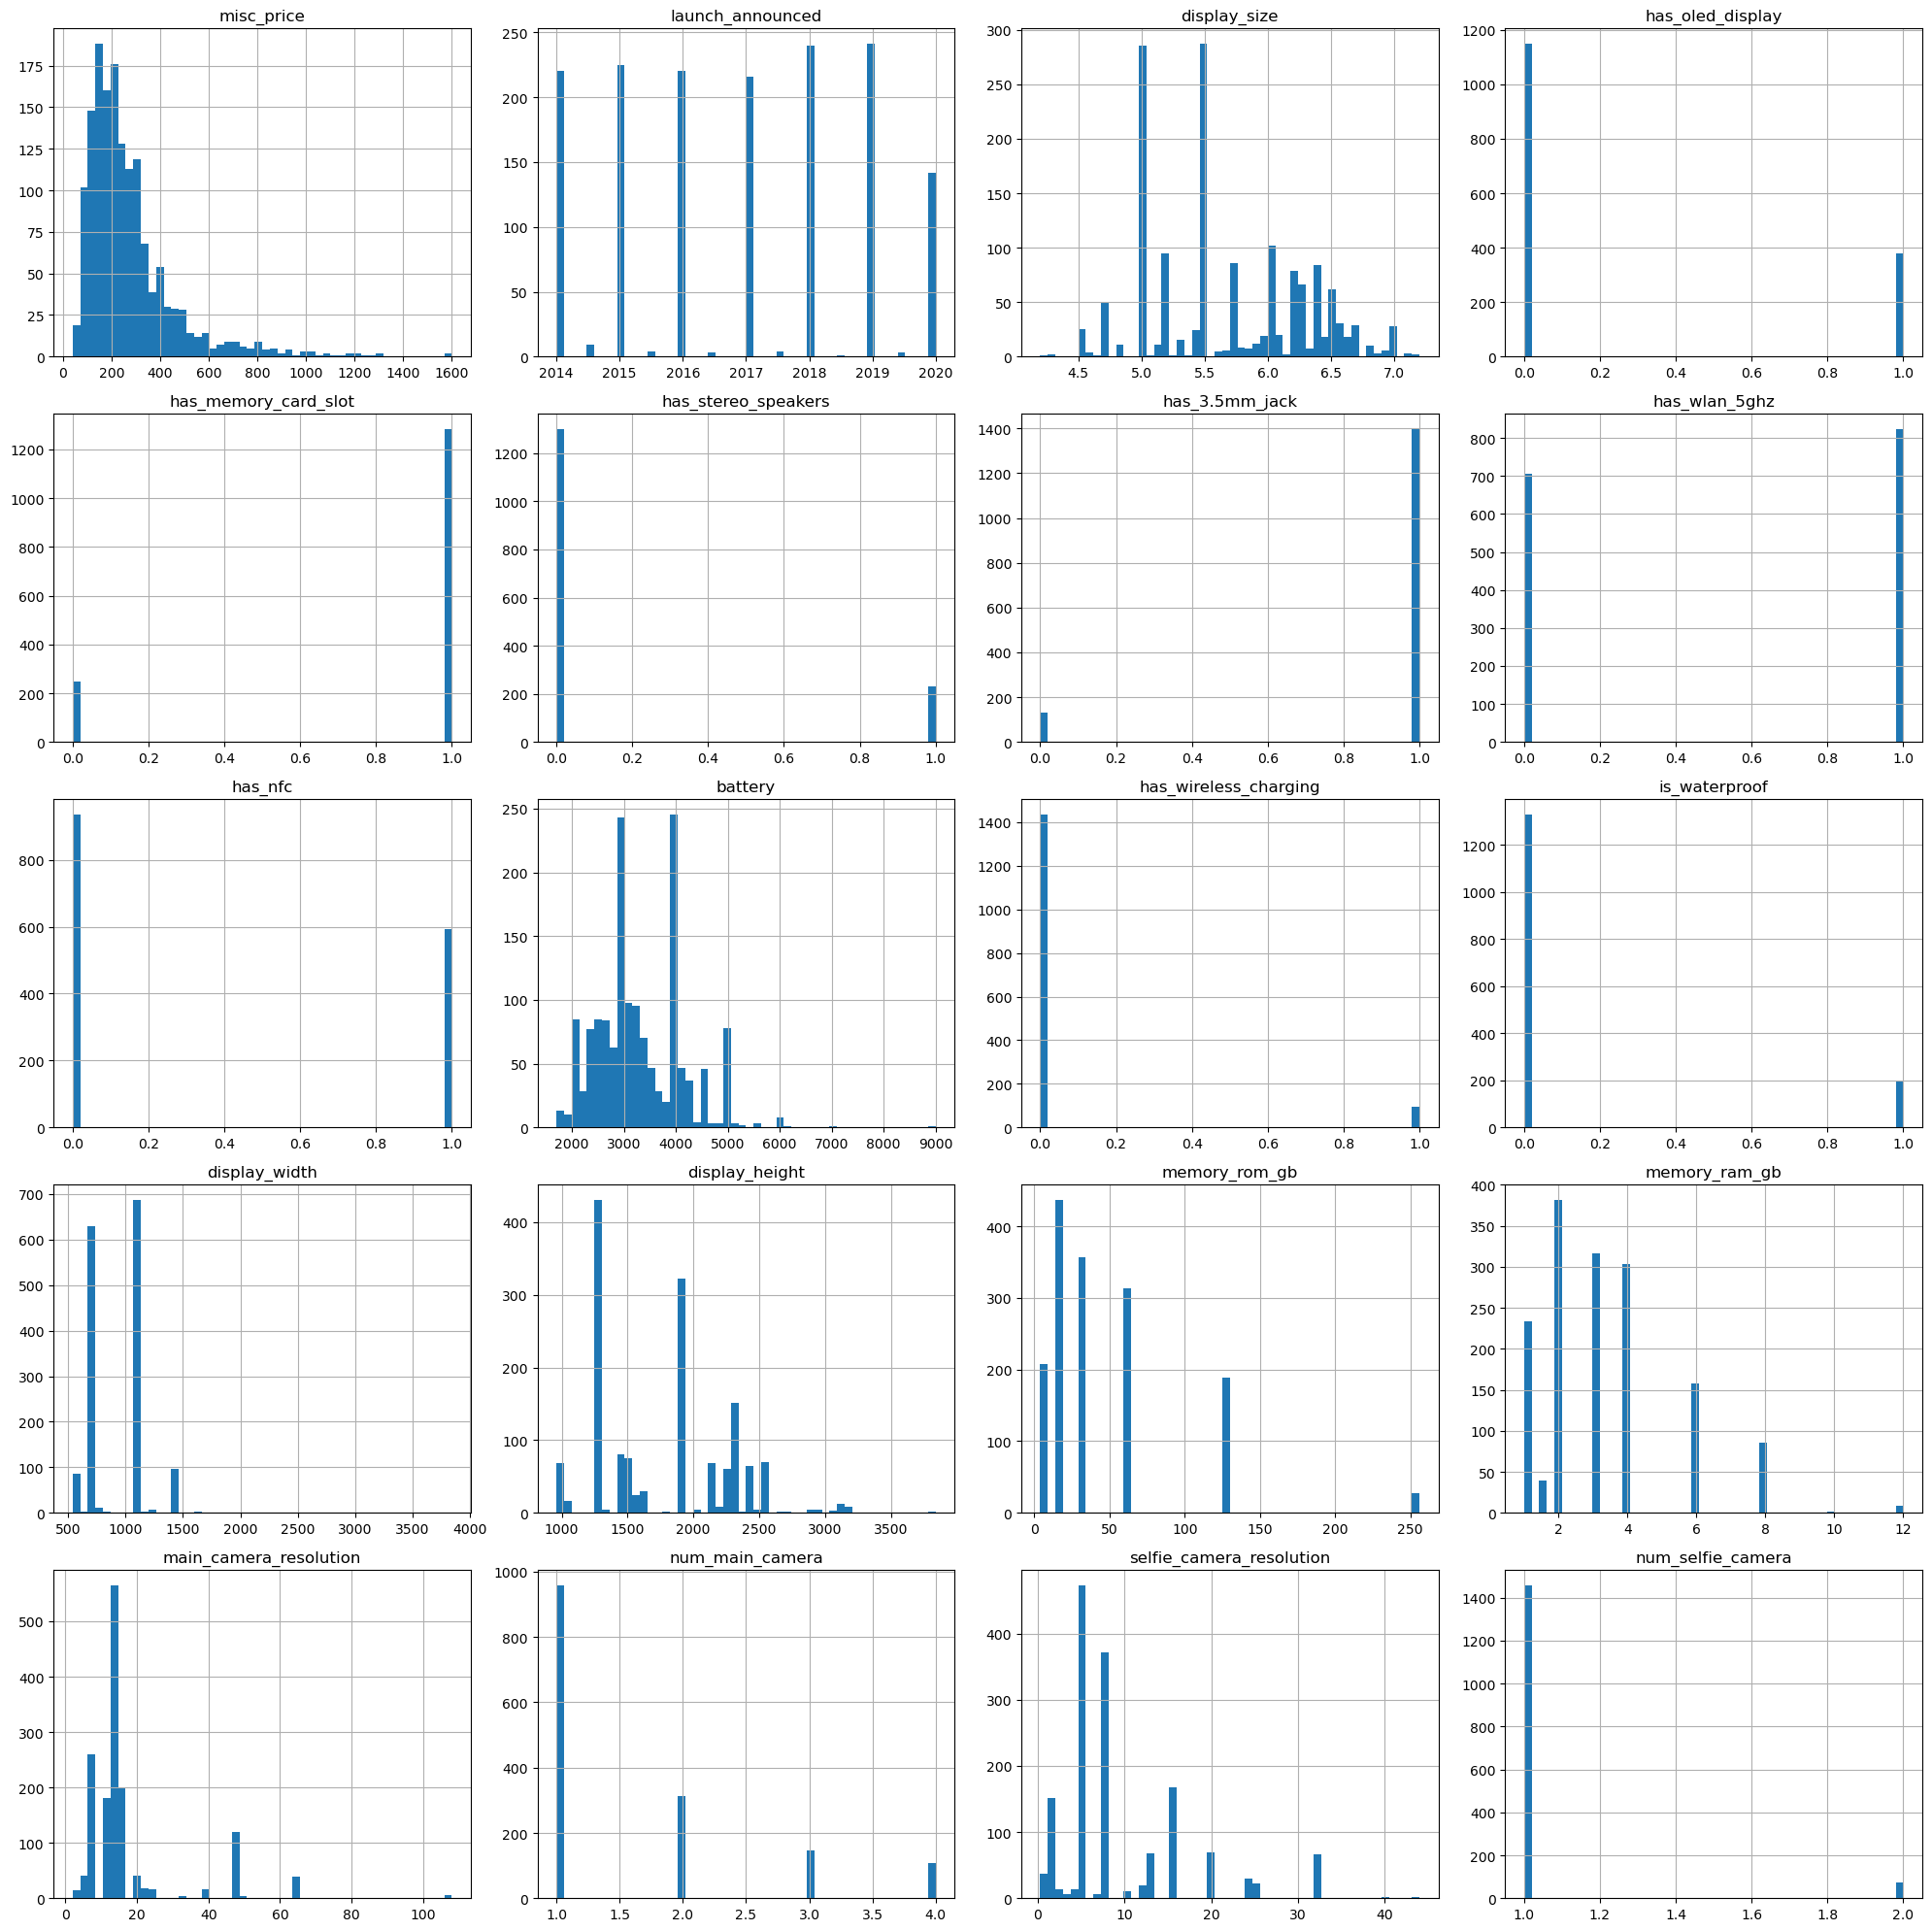

In [11]:
df.hist(figsize=(20, 20), bins=50)
plt.tight_layout()

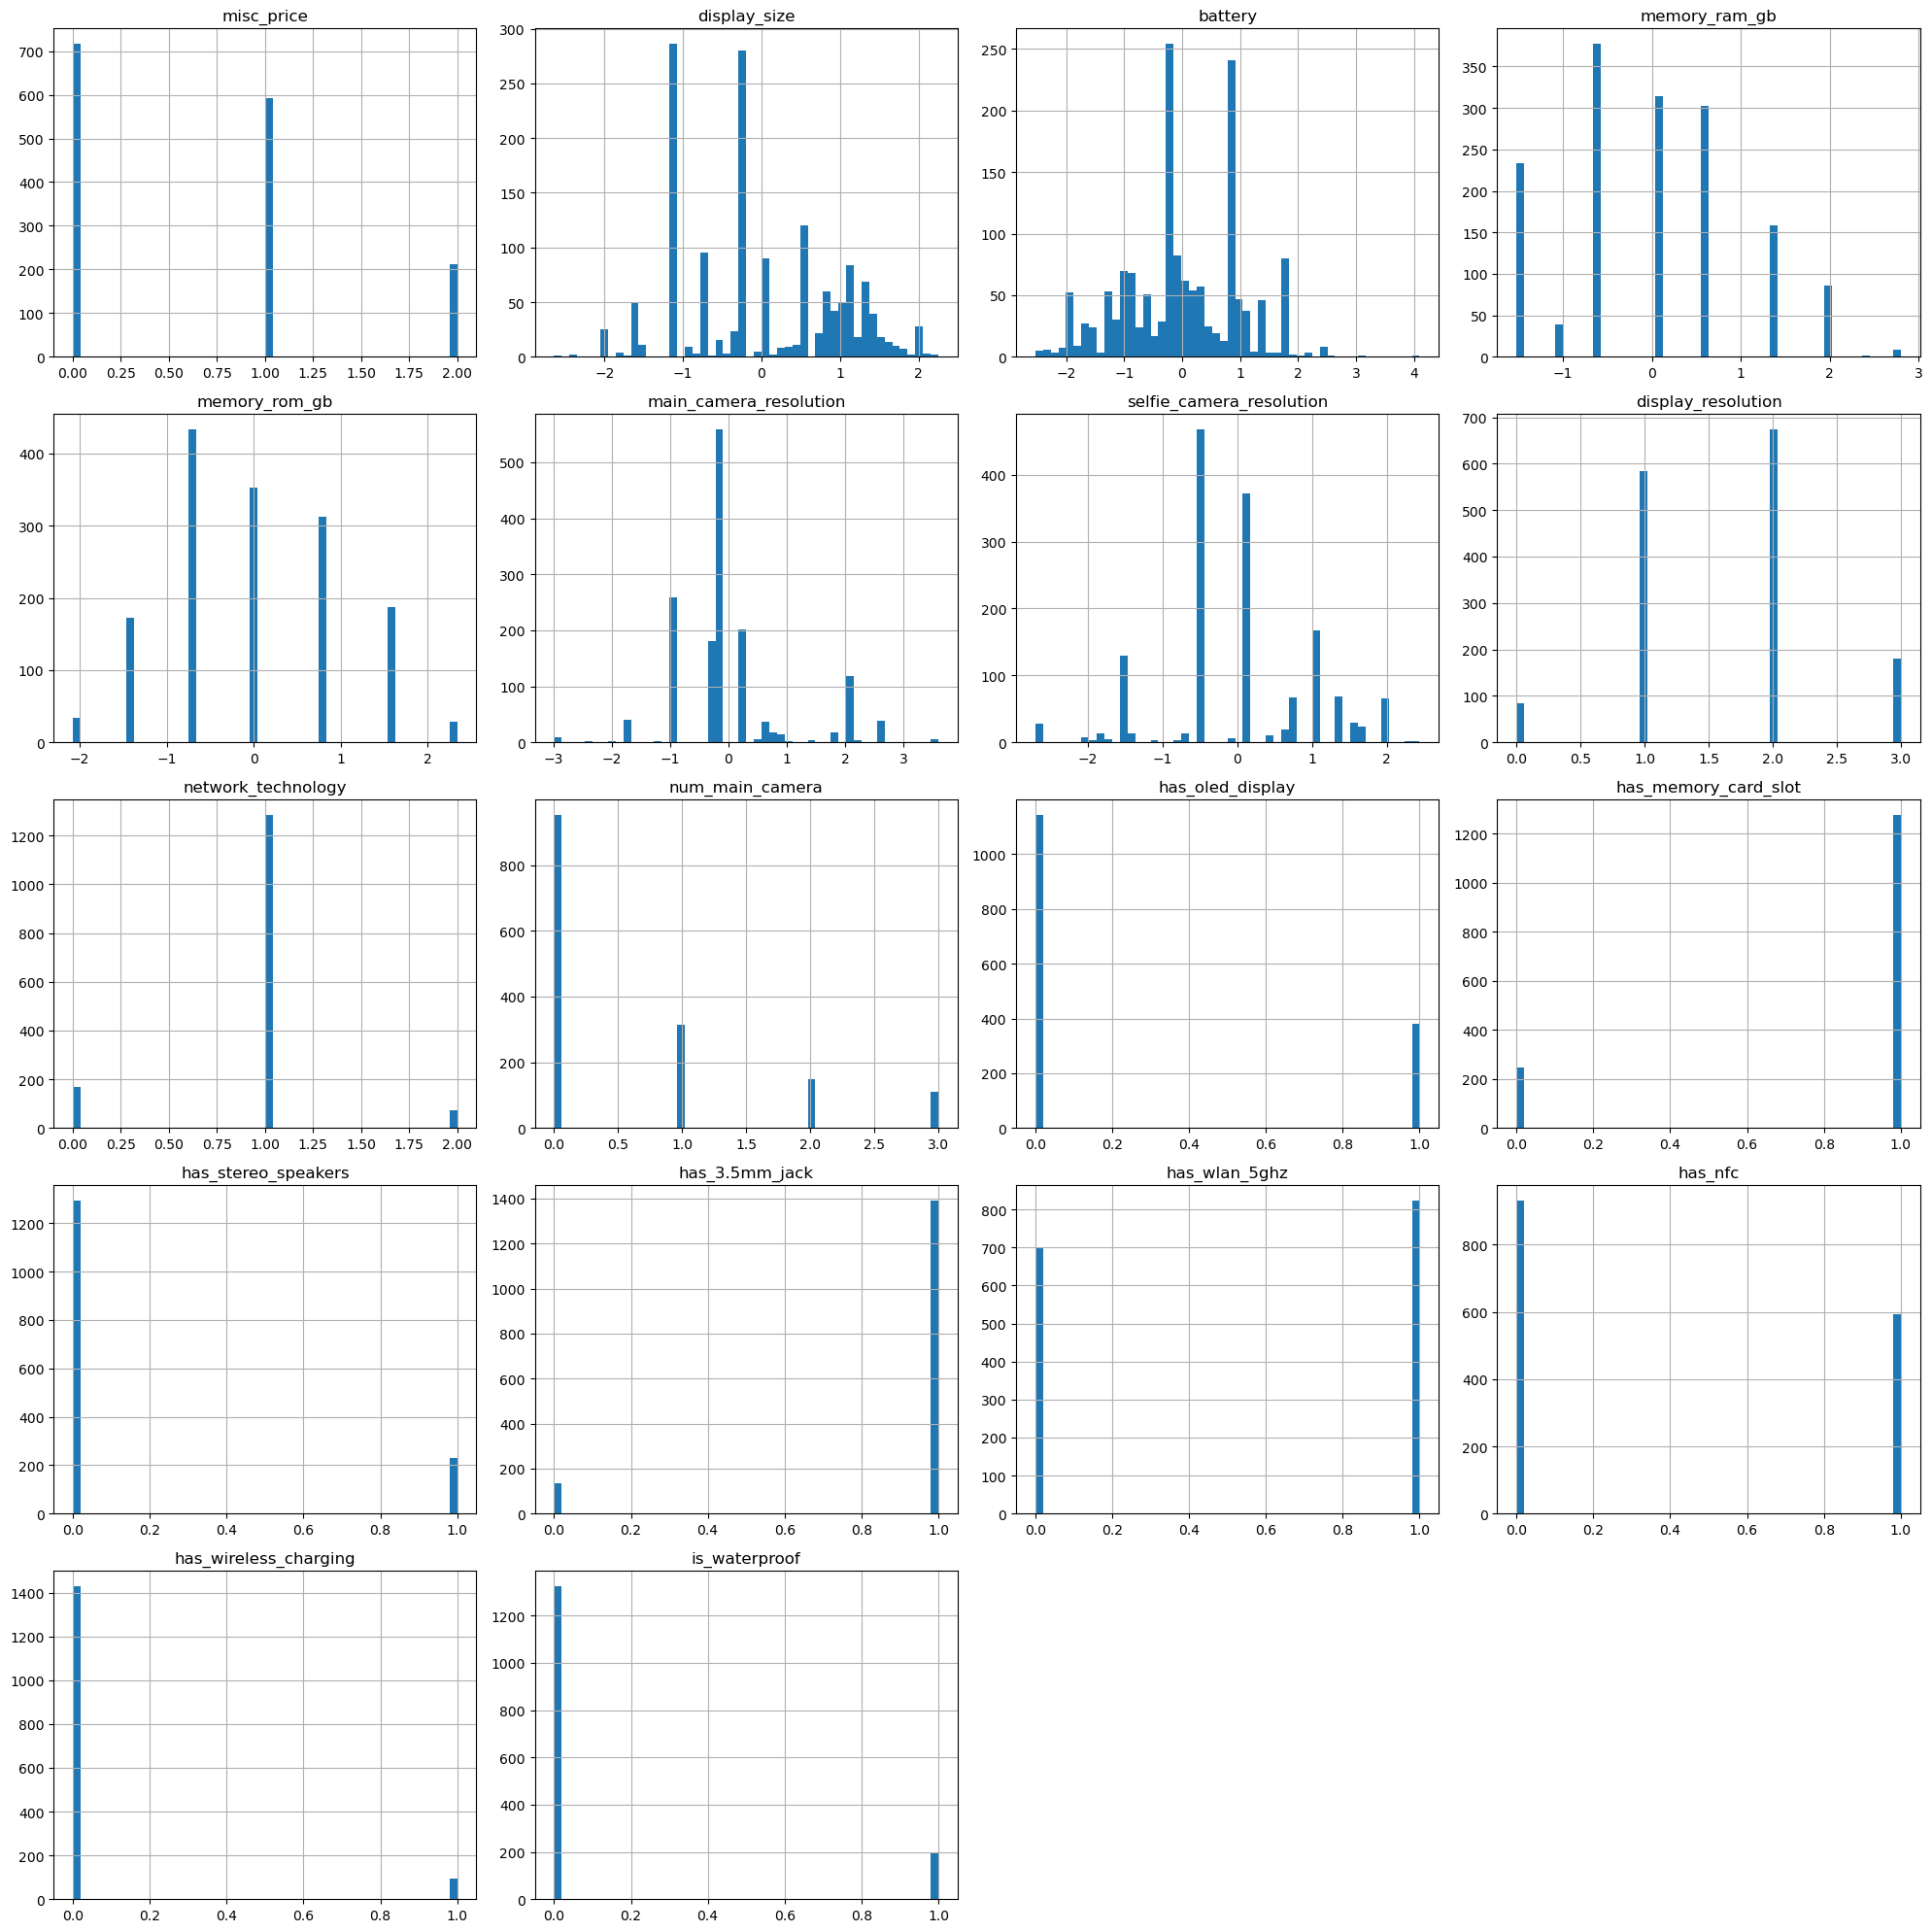

In [12]:
train_preprocess.hist(figsize=(20, 20), bins=50)
plt.tight_layout()

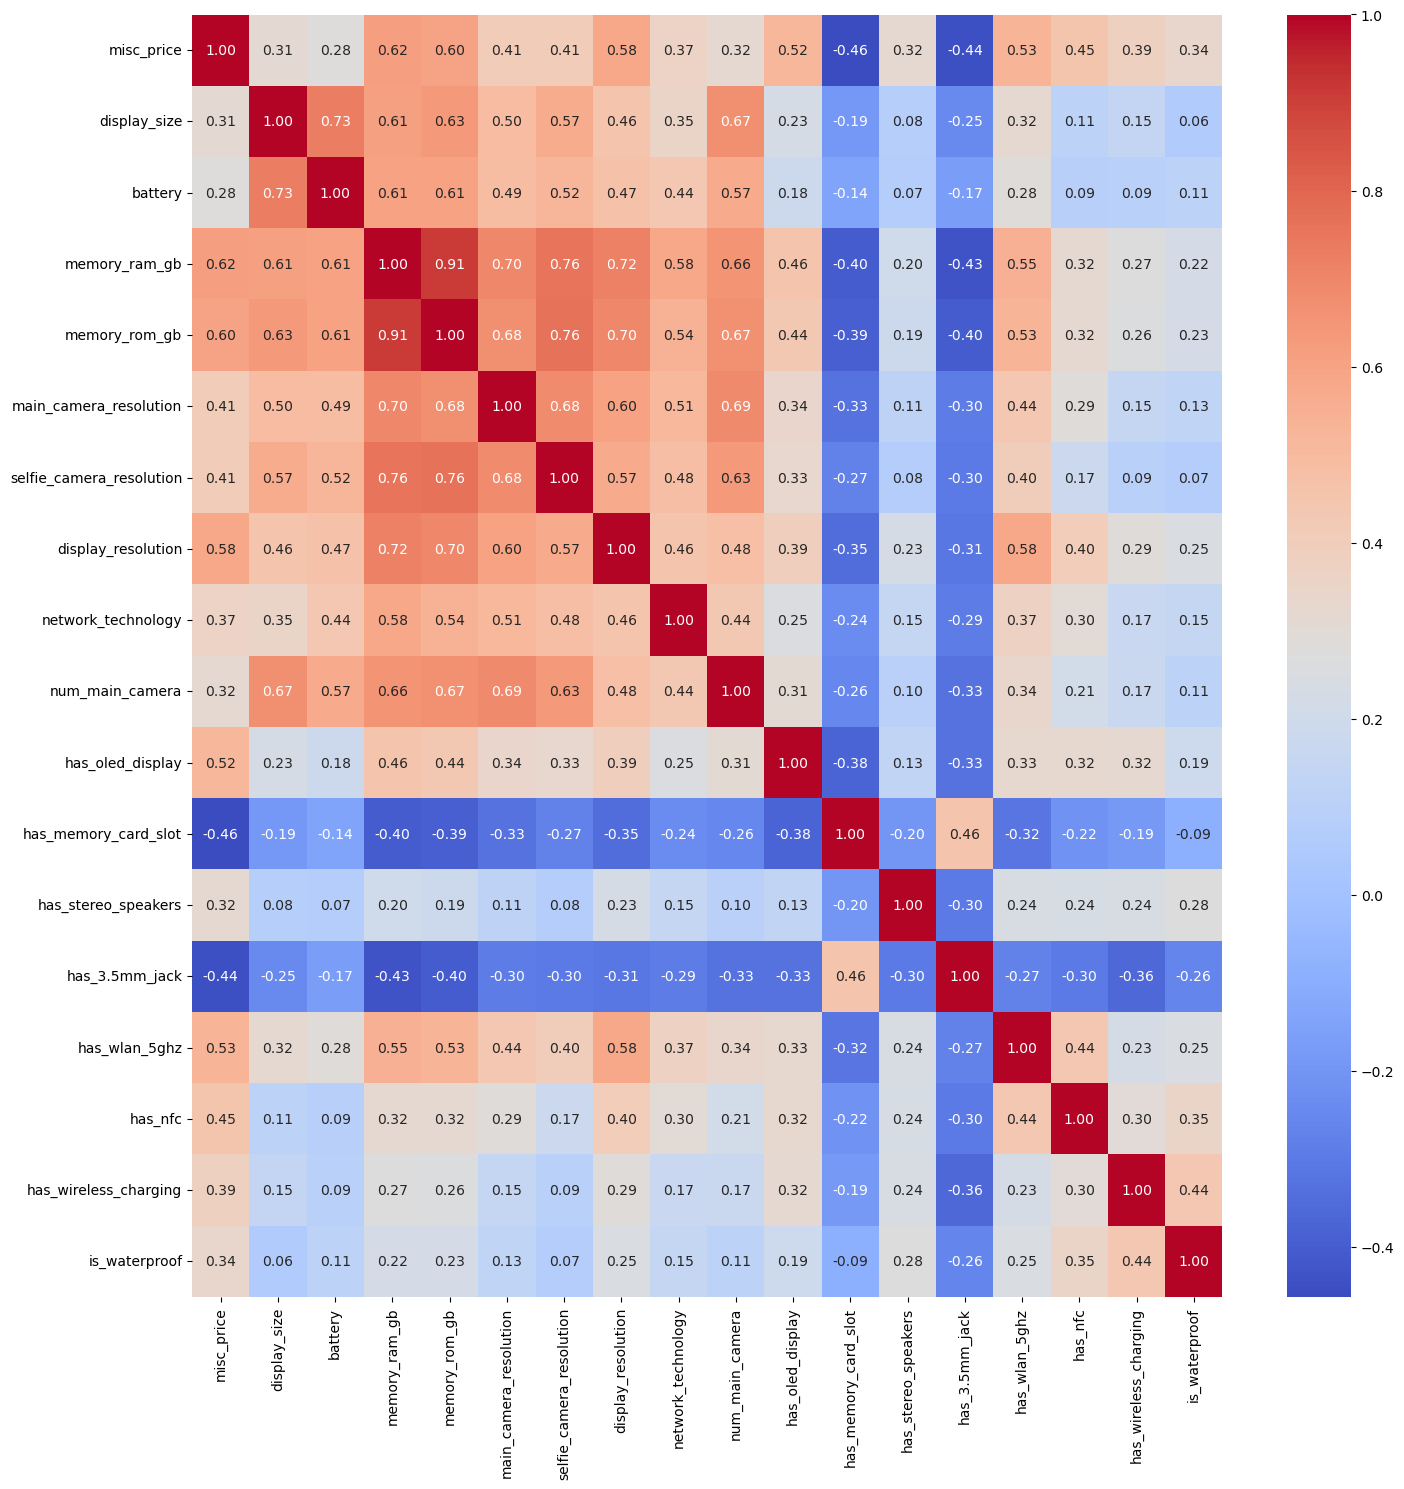

In [14]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_preprocess.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.tight_layout()

,display_size_standard,display_size_inv_standard,display_size_robust,display_size_inv_robust,display_size,display_size_inv
0,-2.642937,4.20,-1.785744,4.20,-2.642937,4.20
1,-2.438177,4.30,-1.633308,4.30,-2.438177,4.30
2,-2.039997,4.50,-1.336879,4.50,-2.039997,4.50
3,-2.000979,4.52,-1.307831,4.52,-2.000979,4.52
4,-1.846305,4.60,-1.192683,4.60,-1.846305,4.60
...,...,...,...,...,...,...
84,1.920417,6.95,1.611496,6.95,1.920417,6.95
85,1.987813,7.00,1.661669,7.00,1.987813,7.00
86,2.121351,7.10,1.761083,7.10,2.121351,7.10
87,2.147860,7.12,1.780818,7.12,2.147860,7.12


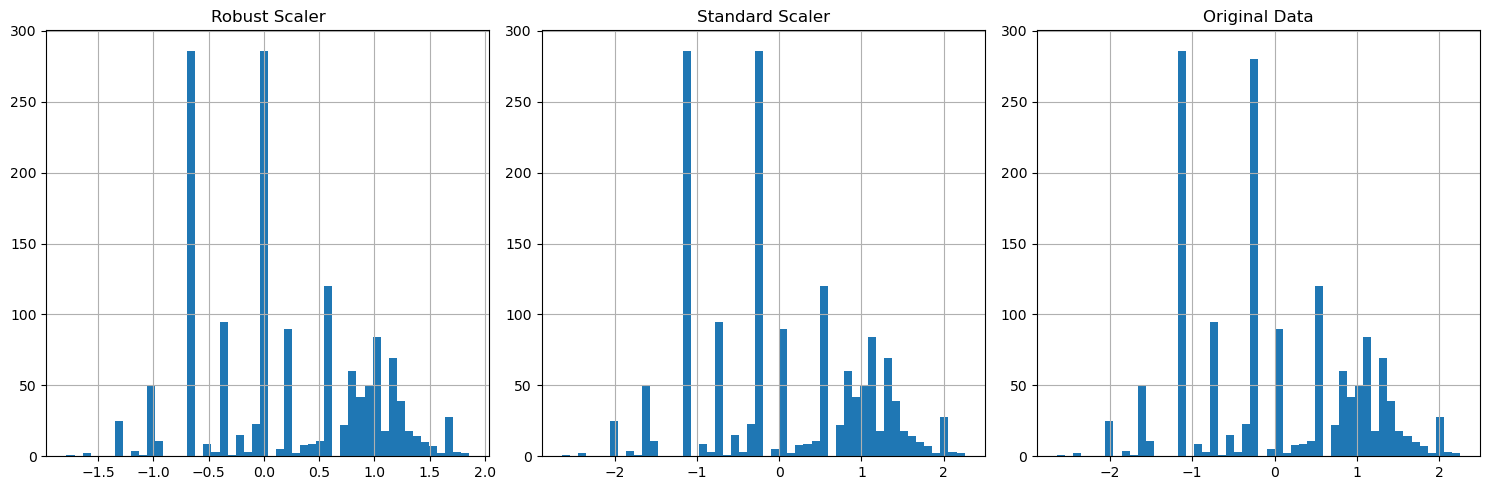

In [115]:
util_data.compare_scalers("display_size", df, train_preprocess, cols_pipeline.transformers_[1][1])

,battery_standard,battery_inv_standard,battery_robust,battery_inv_robust,battery,battery_inv
0,-2.535826,1700.0,-2.114183,1700.0,-2.535826,1700.0
1,-2.500864,1715.0,-2.083273,1715.0,-2.500864,1715.0
2,-2.420459,1750.0,-2.012187,1750.0,-2.420459,1750.0
3,-2.308340,1800.0,-1.913063,1800.0,-2.308340,1800.0
4,-2.286290,1810.0,-1.893569,1810.0,-2.286290,1810.0
...,...,...,...,...,...,...
179,2.484572,6000.0,2.324343,6000.0,2.484572,6000.0
180,2.497822,6020.0,2.336057,6020.0,2.497822,6020.0
181,2.602262,6180.0,2.428392,6180.0,2.602262,6180.0
182,3.098336,7000.0,2.866970,7000.0,3.098336,7000.0


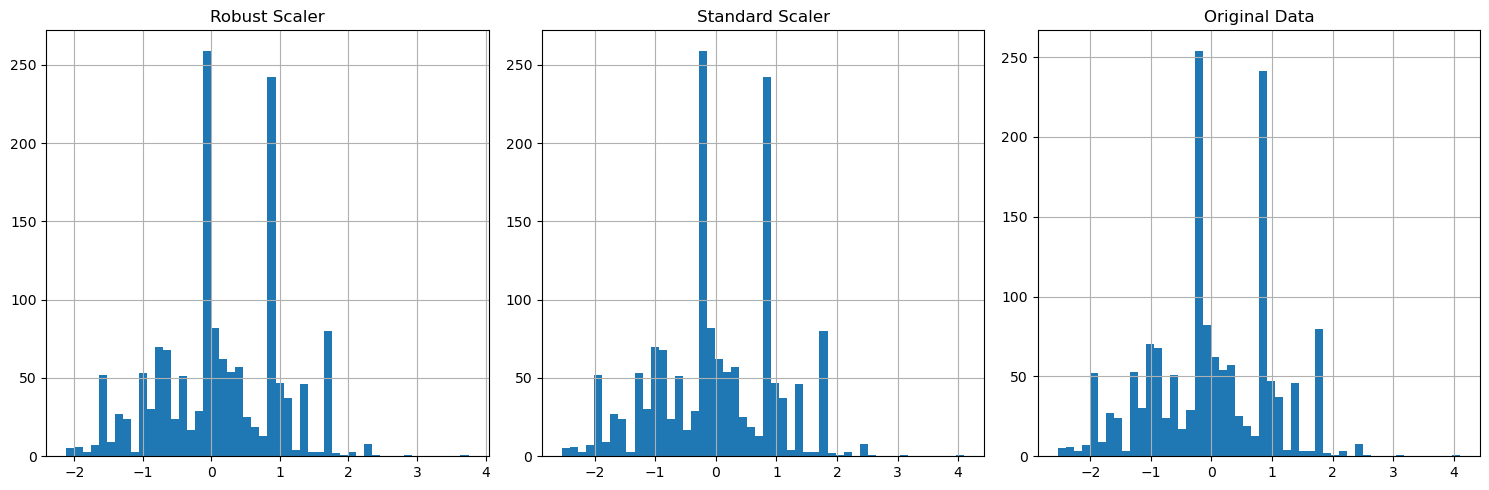

In [116]:
util_data.compare_scalers("battery", df, train_preprocess, cols_pipeline.transformers_[1][1])

,memory_ram_gb_standard,memory_ram_gb_inv_standard,memory_ram_gb_robust,memory_ram_gb_inv_robust,memory_ram_gb,memory_ram_gb_inv
0,-1.522586,1.0,-1.830451,1.0,-1.522586,1.0
1,-1.007253,1.5,-1.241177,1.5,-1.007253,1.5
2,-0.586195,2.0,-0.759706,2.0,-0.586195,2.0
3,0.078186,3.0,0.000000,3.0,0.078186,3.0
4,0.593519,4.0,0.589274,4.0,0.593519,4.0
5,1.370577,6.0,1.477824,6.0,1.370577,6.0
6,1.950969,8.0,2.141491,8.0,1.950969,8.0
7,2.414403,10.0,2.671418,10.0,2.414403,10.0
8,2.800202,12.0,3.112572,12.0,2.800202,12.0


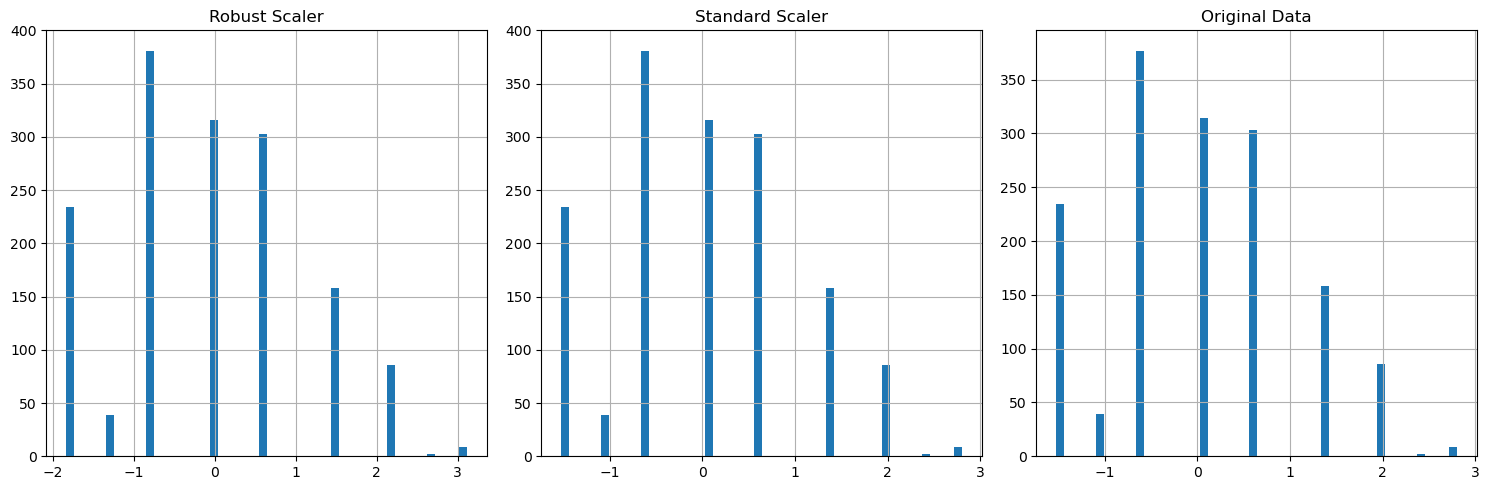

In [117]:
util_data.compare_scalers("memory_ram_gb", df, train_preprocess, cols_pipeline.transformers_[1][1])

,memory_rom_gb_standard,memory_rom_gb_inv_standard,memory_rom_gb_robust,memory_rom_gb_inv_robust,memory_rom_gb,memory_rom_gb_inv
0,-2.078460,4.0,-1.898052,4.0,-2.078460,4.0
1,-1.419126,8.0,-1.306845,8.0,-1.419126,8.0
2,-0.705724,16.0,-0.667155,16.0,-0.705724,16.0
3,0.038308,32.0,0.000000,32.0,0.038308,32.0
4,0.798701,64.0,0.681825,64.0,0.798701,64.0
5,1.567558,128.0,1.371239,128.0,1.567558,128.0
6,2.340720,256.0,2.064514,256.0,2.340720,256.0


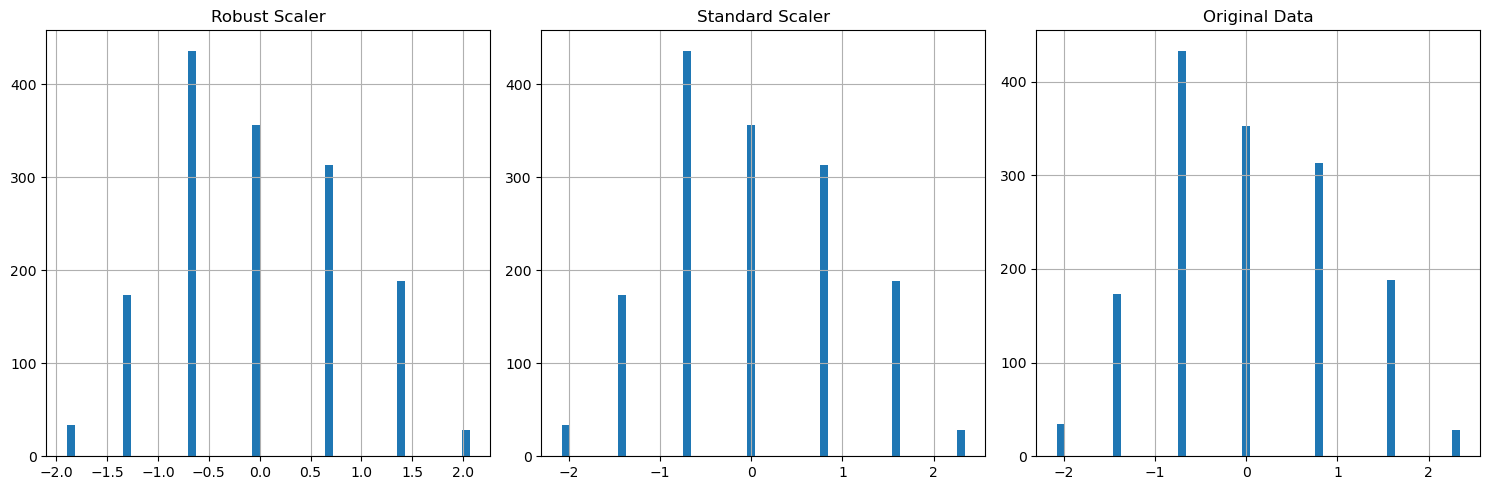

In [118]:
util_data.compare_scalers("memory_rom_gb", df, train_preprocess, cols_pipeline.transformers_[1][1])

,main_camera_resolution_standard,main_camera_resolution_inv_standard,main_camera_resolution_robust,main_camera_resolution_inv_robust,main_camera_resolution,main_camera_resolution_inv
0,-2.994081,2.0,-7.746209,2.0,-2.994986,2.00
1,-2.465968,3.0,-6.299584,3.0,-2.466729,3.00
2,-2.056332,4.0,-5.177495,4.0,-2.399130,3.15
3,-1.721635,5.0,-4.260682,5.0,-2.056982,4.00
4,-1.193522,7.0,-2.814057,7.0,-1.722193,5.00
5,-0.977302,8.0,-2.221779,8.0,-1.264121,6.70
6,-0.608920,10.0,-1.212696,10.0,-0.977658,8.00
7,-0.302250,12.0,-0.372656,12.0,-0.609176,10.00
8,-0.166207,13.0,0.000000,13.0,-0.302422,12.00
9,0.190216,16.0,0.976324,16.0,-0.274388,12.20


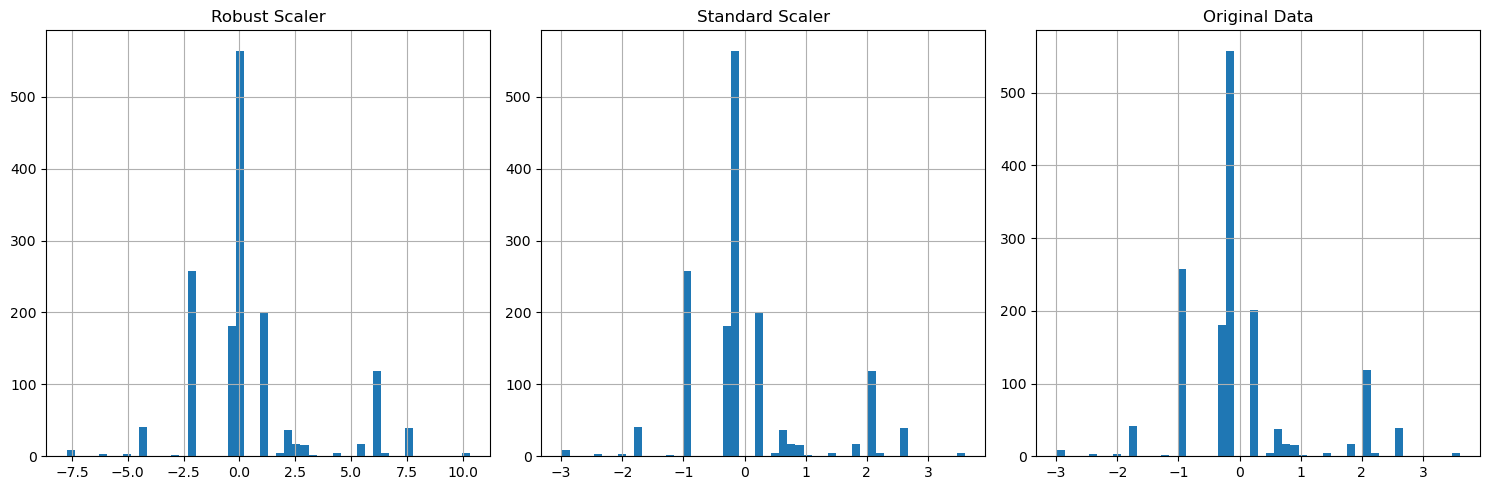

In [120]:
util_data.compare_scalers("main_camera_resolution", df, train_preprocess, cols_pipeline.transformers_[1][1], round=True)

,selfie_camera_resolution_standard,selfie_camera_resolution_inv_standard,selfie_camera_resolution_robust,selfie_camera_resolution_inv_robust,selfie_camera_resolution,selfie_camera_resolution_inv
0,-3.005142,0.0,-3.498192,0.0,-2.703857,0.3
1,-2.022905,1.0,-2.394636,1.0,-2.153475,0.9
2,-1.448333,2.0,-1.749096,2.0,-2.079083,1.0
3,-1.040667,3.0,-1.291079,3.0,-2.008322,1.1
4,-0.724457,4.0,-0.935813,4.0,-1.940853,1.2
5,-0.466095,5.0,-0.645539,5.0,-1.876384,1.3
6,-0.058430,7.0,-0.187522,7.0,-1.698571,1.6
7,0.108477,8.0,0.000000,8.0,-1.540197,1.9
8,0.392841,10.0,0.319487,10.0,-1.491029,2.0
9,0.629568,12.0,0.585453,12.0,-1.443473,2.1


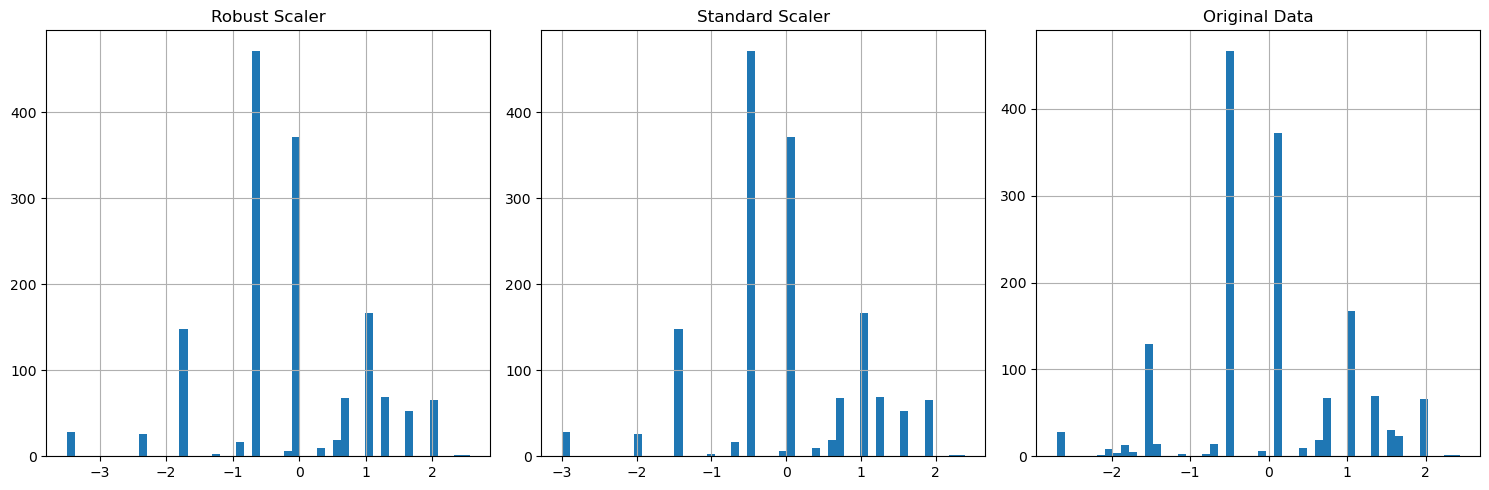

In [122]:
util_data.compare_scalers("selfie_camera_resolution", df, train_preprocess, cols_pipeline.transformers_[1][1], log=True, round=True)